In [22]:
import os
import geopandas as gpd
import pandas as pd
import zipfile36 as zipfile
from io import BytesIO
from urllib.request import urlopen


In [33]:
#first will want to see which tiles are overlapping with the muni
#then go to the excel link to download and unzip
#then figure out how to process 

projects_data_dir = r'K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data'
datasets_dir = r'K:\DataServices\datasets'

#index
index_fp = os.path.join(projects_data_dir, 'Orthoimagery\Index\COQ2021INDEX_POLY.shp')
index = gpd.read_file(index_fp)


#index_excel
index_excel_fp = os.path.join(projects_data_dir, 'Orthoimagery\Index\COQ2021INDEX_POLY.xlsx')
index_lookup = pd.read_excel(index_excel_fp)

#municipalities
munis_fp = os.path.join(datasets_dir, "Boundaries\Spatial\mapc_towns_poly.shp")
munis = gpd.read_file(munis_fp)

#extracted ortho
ortho_dir = os.path.join(projects_data_dir, 'Orthoimagery\Extracted_Ortho_bytown')

#roofprints
roofprints_gdb = os.path.join(datasets_dir, 'MassGIS\Facilities_Structures\Building_Structures\Output\structures.gdb')
roofprints_layer = 'STRUCTURES_POLY'


In [34]:
#find intersect between town and index
muni = 'Revere'

#select muni shape
muni_gdf = munis.loc[munis['municipal'] == muni]

#find intersect
intersecting = index.sjoin(muni_gdf, how='inner')
intersecting.head()

roofprints = gpd.read_file(roofprints_gdb, 
                                    ayer=roofprints_layer, 
                                    mask=muni_gdf) 

roofprints_muni = roofprints.clip(muni_gdf)

<Axes: >

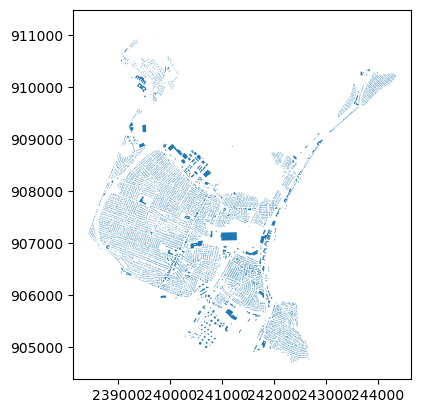

In [35]:
roofprints_muni.plot()

In [29]:
#extract all orto files from overlapping index into a folder for the town

path = os.path.join(ortho_dir, muni) #make a subdirectory in ortho folder w town name
os.makedirs(path, exist_ok=True) 

for url in intersecting['URL'].tolist():
    with urlopen(url) as zipresp:
        with zipfile.ZipFile(BytesIO(zipresp.read())) as zfile:
            zfile.extractall(path)

"\n\n    r = urllib2.urlopen(url)\n    zip_fp = zipfile.ZipFile(BytesIO(r.read()))\n\n    with zipfile.ZipFile(zip_fp, 'r') as zip_ref:\n        \n        zip_ref.extractall(path)\n"

In [37]:
#ok now have to figure out how to get reflectivity from these files!
#https://geopyspark.readthedocs.io/en/v0.1.0/tutorials/sentinel_ingest_example.html

import numpy as np
import rasterio


test_jp2 = r"K:\DataServices\Projects\Current_Projects\Climate_Change\MVP_MMC_CoolRoofs_MVP\Data\Orthoimagery\Extracted_Ortho_bytown\Revere\19TCG330995.jp2"

arrs = []
# Reading the jp2s with rasterio
with rasterio.open(test_jp2) as f:
    arrs.append(f.read(1))

data = np.array(arrs, dtype=arrs[0].dtype)

# saving the max and min values of the tile with
with open('/tmp/sentinel_stats.txt', 'w') as f:
    f.writelines([str(data.max()) + "\n", str(data.min())])

if f.nodata:
    no_data = f.nodata
else:
    no_data = 0

bounds = f.bounds
epsg_code = int(f.crs.to_dict()['init'][5:])

# Creating the RasterRDD
tile = {'data': data, 'no_data_value': no_data}

extent = {'xmin': bounds.left, 'ymin': bounds.bottom, 'xmax': bounds.right, 'ymax': bounds.top}
projected_extent = {'extent': extent, 'epsg': epsg_code}
'''
rdd = geopysc.pysc.parallelize([(projected_extent, tile)])
raster_rdd = RasterRDD.from_numpy_rdd(geopysc, SPATIAL, rdd)

metadata = raster_rdd.collect_metadata()
laid_out = raster_rdd.tile_to_layout(metadata)
reprojected = laid_out.reproject("EPSG:3857", scheme=ZOOM)

pyramided = reprojected.pyramid(start_zoom=12, end_zoom=1)

for tiled in pyramided:
    write("file:///tmp/sentinel-catalog", "sentinel-benchmark", tiled)'''

FileNotFoundError: [Errno 2] No such file or directory: '/tmp/sentinel_stats.txt'